In [ ]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks



def readOldHHS(path, degree, columns=None):
    if degree == 0:
        first_row = 1
        last_row = 101
    elif degree == 90:
        first_row = 102
        last_row = False
    
    df = pd.read_csv(path, header=None, skiprows=first_row, skipfooter=last_row)
    for i in range(len(df)):
        df.loc[i,0] = df.loc[i,0].replace(" ",";").replace(";;",";")
    df = df[0].str.split(';', n=-1, expand=True)
    df.columns = ["test","turns", "idk1", "idk2"]
    df = df.drop("test",axis=1)
    for i in df.columns:
        df[i]=pd.to_numeric(df[i])
    if columns is not None:
        df.columns = columns
    return df

## Old Data Plot

The pascal results consists of four files: .DAT | .RAW | .RES | .LOG

the .RAW has columns turns, voltage, speed

the .DAT has columns turns, voltage, residual

the .RES has all the results and calculations using fourier analysis

the .LOG has most of the metadata related to the motor and multimeters.

c:\Users\guilh\Desktop\dev\hhs-trigger-ui\hhs_tools.py:113: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, header=None, skiprows=first_row, skipfooter=last_row)


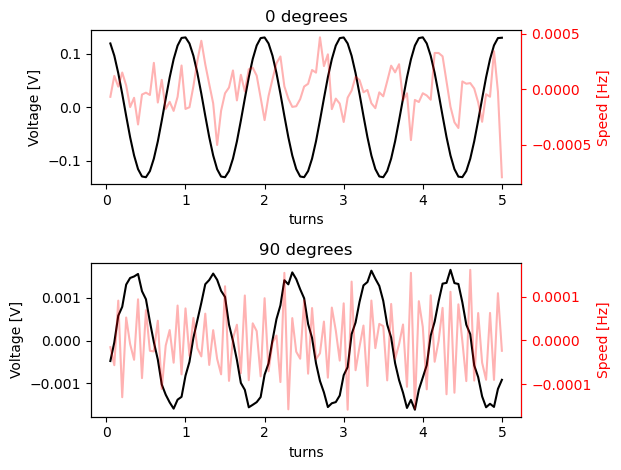

In [ ]:
df_0 = readOldHHS("./N444/N444_A_1.RAW", degree=0, columns=["turns","voltage","Hz"])
df_90 = readOldHHS("./N444/N444_A_1.RAW", degree=90, columns=["turns","voltage","Hz"])

fig, ax = plt.subplots(2)

# Plotting data 0degrees
ax[0].plot(df_0['turns'], df_0['voltage'], label='voltage', color='black')
ax[0].set_xlabel('turns')
ax[0].set_ylabel('Voltage [V]', color='black')
ax[0].set_title('0 degrees')
ax2 = ax[0].twinx()
ax2.plot(df_0['turns'], df_0['Hz'], label='Hz', color='red', alpha=0.3)
ax2.set_ylabel('Speed [Hz]', color='red')
ax2.tick_params(axis='y', colors='red')
ax2.spines['right'].set_color('red')

# Plotting data 90degree
ax[1].plot(df_90['turns'], df_90['voltage'], label='voltage', color='black')
ax[1].set_xlabel('turns')
ax[1].set_ylabel('Voltage [V]', color='black')
ax[1].set_title('90 degrees')
ax3 = ax[1].twinx()
ax3.plot(df_90['turns'], df_90['Hz'], label='Hz', color='red', alpha=0.3)
ax3.set_ylabel('Speed [Hz]', color='red')
ax3.tick_params(axis='y', colors='red')
ax3.spines['right'].set_color('red')

plt.tight_layout()
plt.show()


## Magnetization Pascal

#### Fourier Analysis

In [ ]:
(****************************************************************)
procedure fa;
var
(*   pi   : real;                *)
   npts,npts1: integer;
   ampc           : array[1..64] of real;
   amps           : array[1..64] of real;
   i,j,k,iord     : integer;
   xk             : real;
   xi,xiperiod,xnperiod : real;
   OldWin         : WinCtrlPtrType;
   Delta_phi0     : real;
   Delta_phi90    : real;
   xsign          : real;
begin
      OldWin:=WinActCtrl;

(*      pi:=4.*arctan(1.0);  *)

      xiperiod:=analysisData.PtsPerRev;
      xnperiod:=analysisData.NrOfRev;
      iord    :=analysisData.OrdOfFA;

      if dacdata.endvoltage < 0 then
          xsign := -1.0
          else
          xsign:=1.0;

      npts1:=round(xnperiod*xiperiod);

      if DefineData.zero = 1 then
      begin
(*********** zero degree data *)
      changewin(zeroanalysiswin);

      for i:=1 to iord do
      begin
       ampc[i]:=0.;
       amps[i]:=0.;
       xi:=i;
       xk:=(2.*pi*xi)/xiperiod;


       for j:=1 to npts1 do
       begin
        ampc[i]:=ampc[i] + cos(xsign*xk*realval(j))*ydata0^[1,j];
        amps[i]:=amps[i] + sin(xsign*xk*realval(j))*ydata0^[1,j];
       end;

      ampc[i]:=(2.*ampc[i])/(xnperiod*xiperiod);
      amps[i]:=(2.*amps[i])/(xnperiod*xiperiod);

      phi0[i]:=arctan(-amps[i]/ampc[i]);
      amp0[i]:=ampc[i]/cos(phi0[i]);
      end;

      for j:=1 to ianzdata0[1] do
      begin
        yresdata0^[1,j]:=ydata0^[1,j];
        for i:=1 to iord do
        begin
            xi:=i;
            xk:=(2.*pi*xi)/xiperiod;
            yresdata0^[1,j]:=yresdata0^[1,j] -
                      amp0[i]*cos(xsign*xk*realval(j) + phi0[i]);
        end;
      end;

      end;

      if DefineData.ninety = 1 then
      begin
(*********** ninety degree data *)
      changewin(ninetyanalysiswin);

      for i:=1 to iord do
      begin
       ampc[i]:=0.;
       amps[i]:=0.;
       xi:=i;
       xk:=(2.*pi*xi)/xiperiod ;

       for j:=1 to npts1 do
       begin
        ampc[i]:=ampc[i]+cos(xsign*xk*realval(j))*ydata90^[1,j];
        amps[i]:=amps[i]+sin(xsign*xk*realval(j))*ydata90^[1,j];
       end;

      ampc[i]:=(2.*ampc[i])/(xnperiod*xiperiod);
      amps[i]:=(2.*amps[i])/(xnperiod*xiperiod);
      phi90[i]:=arctan(-amps[i]/ampc[i]);
      amp90[i]:=ampc[i]/cos(phi90[i]);
      writeln(i,' ',amp90[i]:8:5,phi90[i]*(180/pi):8:2);
      end;

      for j:=1 to ianzdata90[1] do
      begin
        yresdata90^[1,j]:=ydata90^[1,j];
        for i:=1 to iord do
        begin
            xi:=i;
            xk:=(2.*pi*xi)/xiperiod;
            yresdata90^[1,j]:=yresdata90^[1,j]-
                    amp90[i]*cos(xsign*xk*realval(j) + phi90[i]);
        end;
      end;

      end;

(********** correction for finite measurement time ********)

if dacdata.endvoltage < 0 then
   xsign:=-1.0
   else
   xsign:=1.0;

Delta_phi0:=0.5*(DVM1Data.Aperture/1000.0)*speed0*2.0*pi;
Delta_phi90:=0.5*(DVM1Data.Aperture/1000.0)*speed90*2.0*pi;

for i := 1 to iord do
    begin
    phi0[i]:=phi0[i]-realval(i)*Delta_phi0;
    phi90[i]:=phi90[i]-realval(i)*Delta_phi90;
    end;

       changewin(ninetyanalysiswin);

(********* amplitudes and phases shall be positive ********)
for i := 1 to iord do
    begin
    if amp0[i] < 0.0 then
       begin
       amp0[i]:=-amp0[i];
       phi0[i]:=phi0[i]+pi;
       end;
(*    if phi0[i] < 0 then
       phi0[i]:=phi0[i]+2.0*pi;  *)
    if phi0[i] > 2.0*pi then
       phi0[i]:=phi0[i]-2.0*pi;
    end;

for i := 1 to iord do
    begin
    if amp90[i] < 0.0 then
       begin
       amp90[i]:=-amp90[i];
       phi90[i]:=phi90[i]+pi;
       end;
(*    if phi90[i] < 0 then
       phi90[i]:=phi90[i]+2.0*pi; *)
    if phi90[i] > 2.0*pi then
       phi90[i]:=phi90[i]-2.0*pi;
    end;

      changewin(oldwin);

      mz:=amp0[1]*cos(phi0[1]);
      my_0:=amp0[1]*sin(phi0[1]);
(* Vorzeichen von Mx geaendert 18.2.1997
   bei der Vermessung der U49 Magnete stand hier ein (+)
   und das Vorzeichen wurde in COMPARE.FOR korrigiert
     mx:=+amp90[1]*cos(phi90[1]); *)
      mx:=-amp90[1]*cos(phi90[1]);
      my_90:=amp90[1]*sin(phi90[1]);

end;

#### Store data Procedure for HHS

In [ ]:
PROCEDURE StoreDataProc_HHS(var ixx:integer);
var
   i,iord,j  : integer;
   radgra    : real;
begin
  (**** store configuration parameters ***)
  if (DefineData.SaveLogFile = 1) then Write_Logfile_HHS;

  (***** store calibrated data **)
    filename := path+CalDataFileName;
    openoutfile(0,0);

    writeln(outfile,ianzdata0[1]);
    for i := 1 to ianzdata0[1] do
        writeln(outfile,xdata0^[i],' ',ydata0^[1,i],' ',
                        yresdata0^[1,i]);

    writeln(outfile,ianzdata90[1]);
    for i := 1 to ianzdata90[1] do
        writeln(outfile,xdata90^[i],' ',ydata90^[1,i],' ',
                        yresdata90^[1,i]);
    closeoutfile(0,0);


  (***** store raw data **)
    filename := path+RawDataFileName;
    openoutfile(0,0);

    writeln(outfile,ianzdata0[1]);
    for i := 1 to ianzdata0[1] do
        writeln(outfile,xdata0^[i],' ',yrawdata0^[i],' ',ydata0^[2,i]);

    writeln(outfile,ianzdata90[1]);
    for i := 1 to ianzdata90[1] do
        writeln(outfile,xdata90^[i],' ',yrawdata90^[i],' ',ydata90^[2,i]);

    closeoutfile(0,0);


  (***** store results *****)
(*    get_north_south_pole; *)
    radgra:=180/pi;
    if definedata.zero = 0 then
    begin
      speed0:=9999;
      amp0[1]:=9999;
    end;
    if definedata.ninety = 0 then
    begin
      speed90:=9999;
      amp90[1]:=9999;
    end;

    filename := path+ResDataFileName;
    openoutfile(0,0);

    writeln(outfile,'**********************');
    writeln(outfile,'Bloc Name: ',BlocNameTmp);
    writeln(outfile,'**********************');
    writeln(outfile, '  ');
    writeln(outfile,'-------------------------');
    writeln(outfile,' M_z      = ',1000.0*(mz/abs(speed0)));
    writeln(outfile,' M_y (0)  = ',1000.0*(my_0/abs(speed0)));
    writeln(outfile,' M_y (90) = ',1000.0*(my_90/abs(speed90)));
    writeln(outfile,' M_x      = ',1000.0*(mx/abs(speed90)));
    writeln(outfile,'-------------------------');
    writeln(outfile,'  ');
    writeln(outfile,' north pole (KGauss) = ',npole);
    writeln(outfile,' south pole (KGauss) = ',spole);
    writeln(outfile,'  ');
    writeln(outfile,' temperature (deg. C): ',Temperature);
    writeln(outfile,'  ');
    writeln(outfile,'-------------------------');
    writeln(outfile,' zero degree position');
    writeln(outfile,'-------------------------');
    writeln(outfile,'  ');
    writeln(outfile,' averaged speed (Hz): ',speed0);
    writeln(outfile,'  ');
    writeln(outfile,'  normalized data_rms (0 degree) (0/00): ',
                       1000.0*(data0_rms/amp0[1]));
    writeln(outfile,' normalized speed_rms (0 degree) (0/00): ',
                      1000.0*(speed0_rms/speed0));
    writeln(outfile,'  ');
    iord:=AnalysisData.OrdOfFA;
    writeln(outfile,' order of Fourier analysis: ',iord);

    for i:=1 to iord do
    begin
      writeln(outfile,' ',i,' amplitude (0) (mV/Hz): ',
                            1000.0*(amp0[i]/speed0));
      writeln(outfile,' ',i,' phase (0) (rad): ',phi0[i]*radgra);
    end;

    writeln(outfile,'  ');
    writeln(outfile,'-------------------------');
    writeln(outfile,' ninety degree position');
    writeln(outfile,'-------------------------');
    writeln(outfile,'  ');
    writeln(outfile,' averaged speed (Hz): ',speed90);
    writeln(outfile,'  ');
    writeln(outfile,'  normalized data_rms (90 degree) (0/00): ',
                       1000.0*(data90_rms/amp90[1]));
    writeln(outfile,' normalized speed_rms (90 degree) (0/00): ',
                      1000.0*(speed90_rms/speed90));
    writeln(outfile,'  ');
    iord:=AnalysisData.OrdOfFA;
    writeln(outfile,' order of Fourier analysis: ',iord);

    for i:=1 to iord do
    begin
      writeln(outfile,' ',i,' amplitude (90) (mV/Hz): ',
                        1000.0*(amp90[i]/speed90));
      writeln(outfile,' ',i,' phase (90) (rad): ',phi90[i]*radgra);
    end;

    closeoutfile(0,0);

end;

## Magnetization Python

In [49]:


df_raw = readOldHHS("N444_A_1.RAW", degree=0, columns=["turns","voltage","Hz"])
df_dat = readOldHHS("N444_A_1.DAT", degree=0, columns=["turns","voltage","residual"])

DVM1Data_Aperture = 0.01 # value for NPLC=1

radgra = 180 / math.pi

yrawdata = np.array(df_raw["voltage"])
ycorrdata = np.array(df_dat["voltage"])

yresdata = np.array(df_dat["residual"])
N = len(ycorrdata)
freq = df_raw["Hz"].mean()
T = (df_dat["turns"][1] - df_dat["turns"][0]) / freq

# Fourier Analysis
fy = fft(ycorrdata)
xf = fftfreq(N, T)[:N//2]

print(fy.shape)

amp0 = 2.0/N * np.abs(fy[0:N//2])
idx = np.argmax(np.abs(fy))
ampc = float(2 * np.real(fy[idx]) / N)
amps = 2 * np.imag(fy[idx]) / N
phi = math.atan2(-amps, ampc)
print(phi)
print(ampc)
print(amps)
amp = ampc / math.cos(phi)

# Phase corrections for 0 degrees
Delta_phi = 0.5 * DVM1Data_Aperture * 2.0 * math.pi * freq
phi += Delta_phi

if amp < 0.0:
    amp = -amp
    phi += math.pi
if phi > 2.0 * math.pi:
    phi -= 2.0 * math.pi

# Calculate magnetization components for 0 degrees

mz = amp * math.cos(phi)
my_0 = amp * math.sin(phi)

print('-----------------------------------')
print(f' M_z      = {1000 * mz / abs(freq): .14E}')
print(f' M_y (0)  = {1000 * my_0 / abs(freq): .14E}')
print('')
print('--------- 0 Degrees----------------')
print(f' averaged speed (Hz): {freq: .14E}')
print(f' 1 amplitude (0) (mV/Hz): {1000*amp/freq: .14E}')
print(f' 1 phase (0) (rad): {phi: .14E}')
print('')

Number of turns: 5.0
Number of samples per period: 20.0
xk: 0.3141592653589793
-------- Fourier Analysis --------
ampc: 0.11984623328550004
amps: 0.05605912959030134
phi [rad]: 0.4375236045834897
phi [deg]: 25.06825597998464
amp: 0.13230928026085206
Delta_phi: 0.12977600044938908
phi before: 0.4375236045834897
phi corrected: 0.3077476041341006
 -------- Adjusting amplitudes -------- 
amp: 0.13230928026085206
phi: 0.3077476041341006
math.sin(phi) = 0.3029128322367017
math.cos(phi) = 0.9530182663865052
mz: 0.1260931609010435
my: 0.04007817881501423
Mz: 61.04878353207083
My: 19.40409809186711
